Date: 03/19/2025 \
Author: Nasheed Jafri \
Purpose: Initial model exploration for the alzheimers dataset from kaggle.

# **Model Exploration**

P.S. I tried to make things consistent with Seyed's notebook because I like how he structured his work. I explored the following models:

- Stochastic Gradient Descent (GradientBoostingClassifier)
- (Gaussian) Naǐve Bayes
- Linear Discriminant Analysis
- Quadratic Disciminant Analysis

Each model is examined on various subcategories of features and the accuracy rates are compared.

In [24]:
# Import all necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report, confusion_matrix

In [4]:
# Load Data
df = pd.read_csv("../data/kaggle_train.csv")
df = df.drop(columns=['DoctorInCharge', 'PatientID'])

In [6]:
# Define subfeature categories
all_features = [   'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}

In [8]:
# Split Data
df_train, df_test = train_test_split(df, random_state=123, shuffle=True, test_size=0.2, stratify=df['Diagnosis'])

In [9]:
# # Identify categorical and numerical features
# categorical_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
# numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features.remove('Diagnosis') if 'Diagnosis' in categorical_features else None
# numerical_features.remove('Diagnosis') if 'Diagnosis' in numerical_features else None

## **Stochastic Gradient Descent (GradientBoostingClassifier)**

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_pipe = Pipeline([('scale', StandardScaler()), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_accu_score = {}
gbc_conf_matrix = {}

for key in subcategory_dict:
    item = subcategory_dict[key]
    gbc_pipe.fit(df_train[item[:-1]], df_train.Diagnosis)
    pred = gbc_pipe.predict(df_test[item[:-1]])

    gbc_accu_score[key] = [accuracy_score(pred, df_test.Diagnosis),
                           precision_score(pred, df_test.Diagnosis, zero_division=1),
                           recall_score(pred, df_test.Diagnosis),
                           f1_score(pred, df_test.Diagnosis),
                           mean_squared_error(pred, df_test.Diagnosis)]
    gbc_conf_matrix[key] = confusion_matrix(pred, df_test.Diagnosis)

gbc_accu_score_df = pd.DataFrame(gbc_accu_score, index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'MSE'])
gbc_accu_score_df

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy Score,0.950581,0.648256,0.639535,0.648256,0.625000,0.953488,0.639535,0.633721
Precision Score,0.925620,0.066116,0.066116,0.024793,0.123967,0.917355,0.008264,0.099174
Recall Score,0.933333,0.500000,0.421053,0.500000,0.394737,0.948718,0.200000,0.413793
F1 Score,0.929461,0.116788,0.114286,0.047244,0.188679,0.932773,0.015873,0.160000
MSE,0.049419,0.351744,0.360465,0.351744,0.375000,0.046512,0.360465,0.366279


**NOTE:** I performed a hyperparaneter tuning using GridSearchCV and strangely **got poorer results** than what I got above, probably because the best parameters are not in my grid.

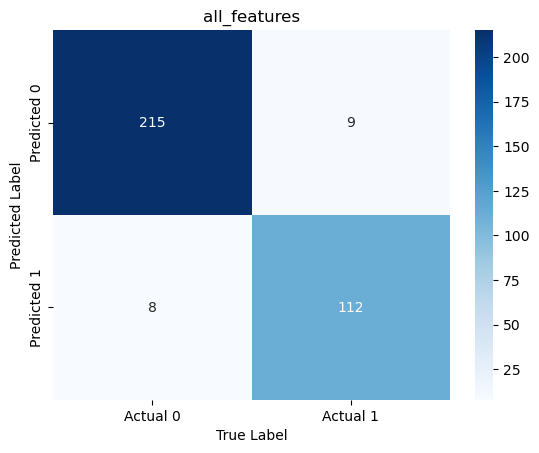

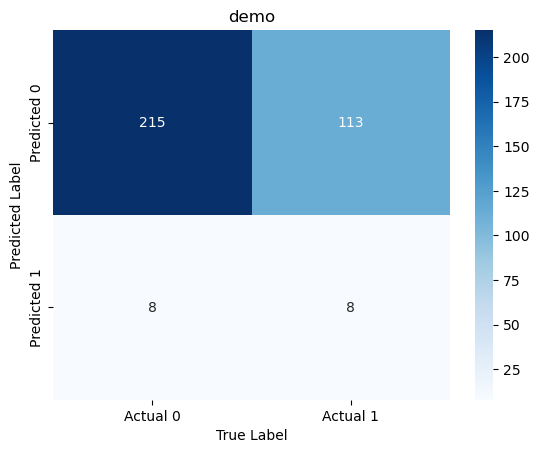

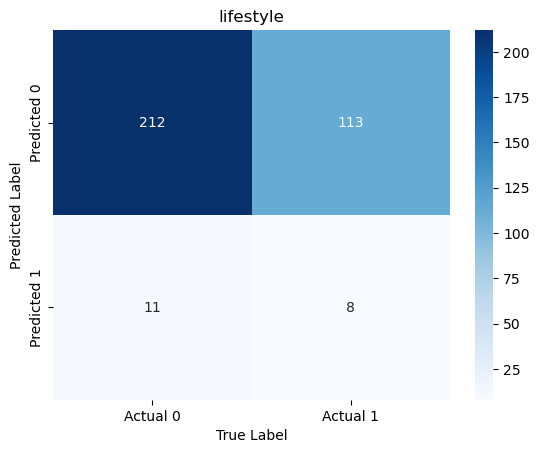

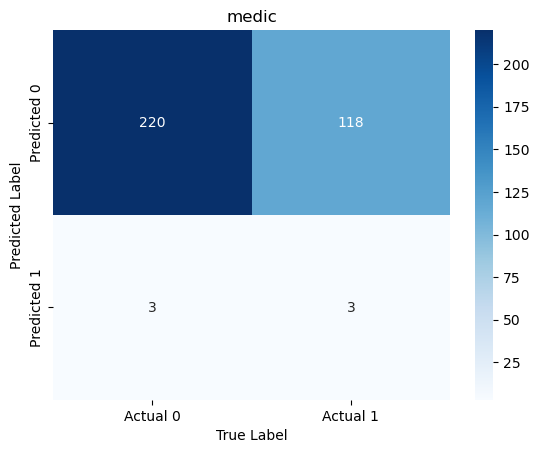

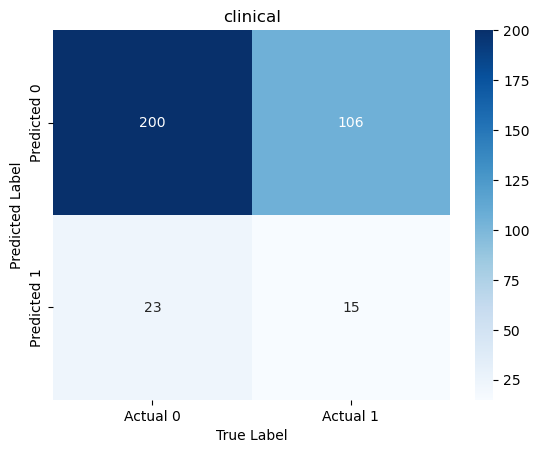

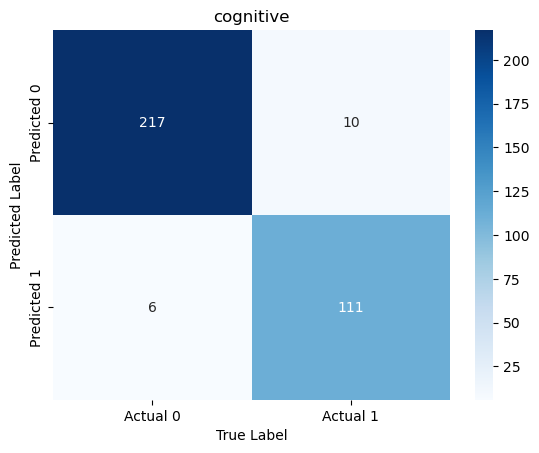

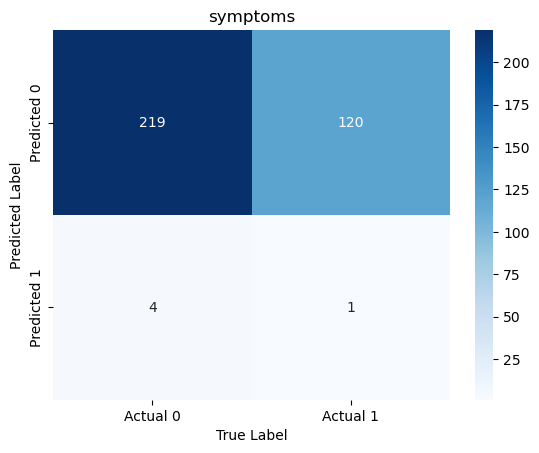

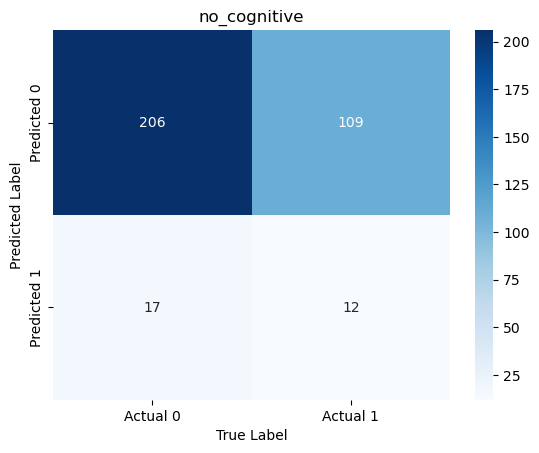

In [35]:
for key,item in gbc_conf_matrix.items():
    sns.heatmap(item, annot=True, fmt="d", cmap="Blues", yticklabels=["Predicted 0", "Predicted 1"], xticklabels=["Actual 0", "Actual 1"])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.title(key)
    plt.show()

In [19]:
# WEIRD! GridSearch gave poorer results...??
## WARNING: THE FOLLOWING CODE TAKES VERY LONG TO EXECUTE!!

# Define hyperparameter grid
param_grid = {
    'gbc__learning_rate': [0.05, 0.1, 0.2],
    'gbc__n_estimators': [50, 100],
    'gbc__max_depth': [3, 5]
}

# Initialize pipeline
gbc_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

gbc_accu_score = {}
best_params_dict = {}

for key in subcategory_dict:
    item = subcategory_dict[key]
    
    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(gbc_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(df_train[item[:-1]], df_train.Diagnosis)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Make predictions
    pred = best_model.predict(df_test[item[:-1]])

    # Store best hyperparameters
    best_params_dict[key] = grid_search.best_params_

    # Store accuracy scores
    gbc_accu_score[key] = [
        accuracy_score(pred, df_test.Diagnosis),
        precision_score(pred, df_test.Diagnosis, zero_division=1),
        recall_score(pred, df_test.Diagnosis),
        f1_score(pred, df_test.Diagnosis),
        mean_squared_error(pred, df_test.Diagnosis),
        grid_search.best_params_['gbc__learning_rate'],
        grid_search.best_params_['gbc__n_estimators'],
        grid_search.best_params_['gbc__max_depth']
    ]

gbc_accu_score_df = pd.DataFrame(
    gbc_accu_score, 
    index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'MSE', 
           'Best Learning Rate', 'Best n_estimators', 'Best Max Depth']
)
gbc_accu_score_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy Score,0.941860,0.648256,0.642442,0.648256,0.642442,0.953488,0.648256,0.648256
Precision Score,0.917355,0.008264,0.000000,0.024793,0.074380,0.909091,0.000000,0.033058
Recall Score,0.917355,0.500000,0.000000,0.500000,0.450000,0.956522,0.000000,0.500000
F1 Score,0.917355,0.016260,0.000000,0.047244,0.127660,0.932203,0.000000,0.062016
MSE,0.058140,0.351744,0.357558,0.351744,0.357558,0.046512,0.351744,0.351744
Best Learning Rate,0.200000,0.050000,0.050000,0.100000,0.100000,0.050000,0.050000,0.050000
Best n_estimators,50.000000,50.000000,50.000000,100.000000,50.000000,100.000000,50.000000,50.000000
Best Max Depth,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


## **Gaussian Naǐve Bayes**

In [37]:
# Making the pipeline
gnb_pipe = Pipeline([('scale', StandardScaler()), ('gnb', GaussianNB())])

# Accuracy score for each subcategory of features
gnb_accu_score = {}
gnb_conf_matrix = {}

# Running the classifier through each subcategory
for key in subcategory_dict:
    item = subcategory_dict[key]
    gnb_pipe.fit(df_train[item[:-1]], df_train.Diagnosis)
    pred = gnb_pipe.predict(df_test[item[:-1]])
    
    gnb_accu_score[key] = [accuracy_score(pred, df_test.Diagnosis),
                           precision_score(pred, df_test.Diagnosis, zero_division=1),
                           recall_score(pred, df_test.Diagnosis),
                           f1_score(pred, df_test.Diagnosis),
                           mean_squared_error(pred, df_test.Diagnosis)]
    gnb_conf_matrix[key] = confusion_matrix(pred, df_test.Diagnosis)

gnb_accu_score_df = pd.DataFrame(gnb_accu_score, index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'MSE'])
gnb_accu_score_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: 

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy Score,0.831395,0.648256,0.648256,0.633721,0.648256,0.834302,0.648256,0.613372
Precision Score,0.727273,0.000000,0.000000,0.024793,0.000000,0.727273,0.000000,0.074380
Recall Score,0.778761,0.000000,0.000000,0.272727,0.000000,0.785714,0.000000,0.300000
F1 Score,0.752137,0.000000,0.000000,0.045455,0.000000,0.755365,0.000000,0.119205
MSE,0.168605,0.351744,0.351744,0.366279,0.351744,0.165698,0.351744,0.386628


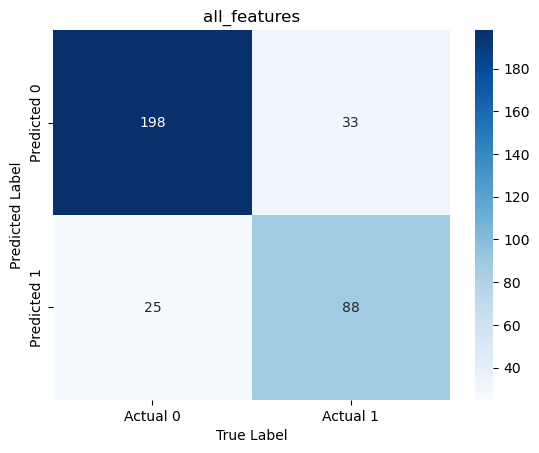

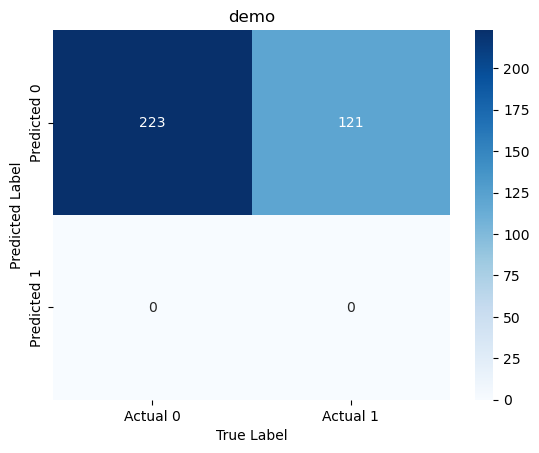

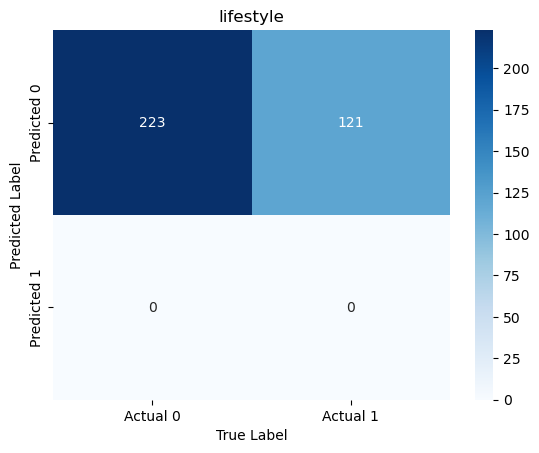

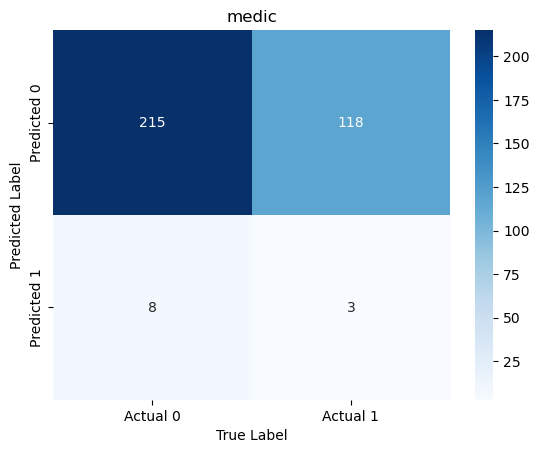

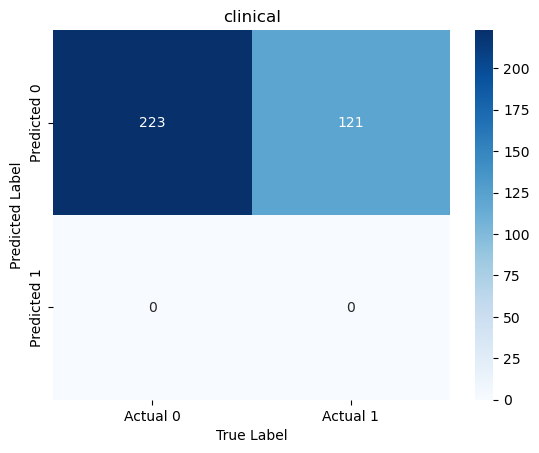

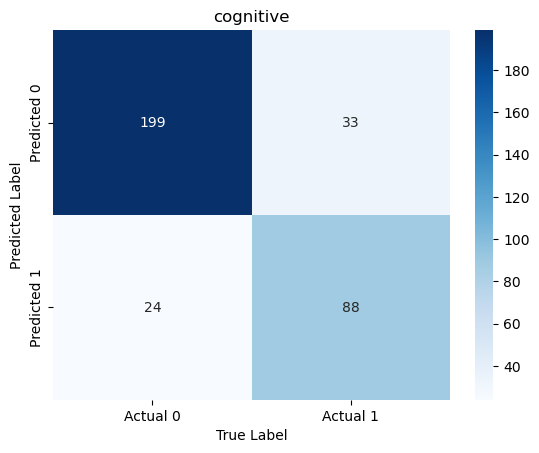

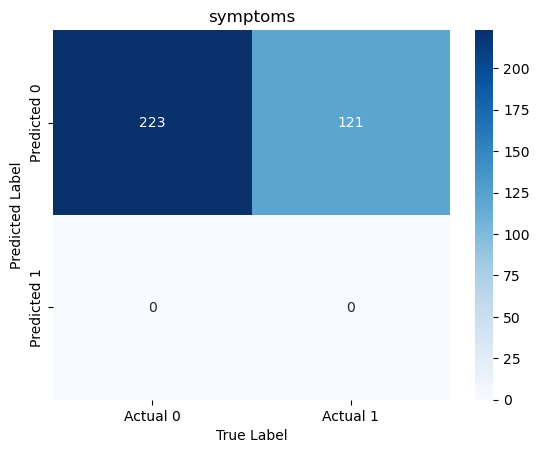

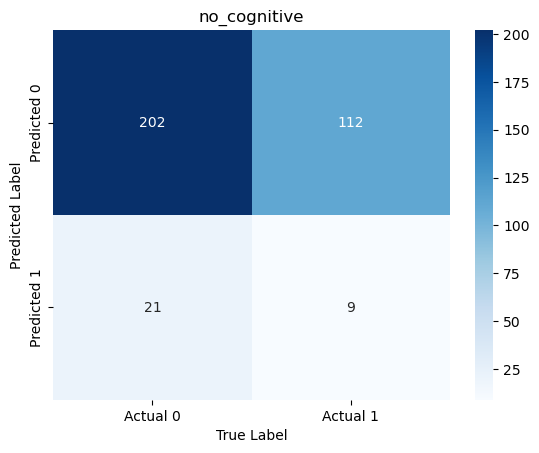

In [39]:
for key,item in gnb_conf_matrix.items():
    sns.heatmap(item, annot=True, fmt="d", cmap="Blues", yticklabels=["Predicted 0", "Predicted 1"], xticklabels=["Actual 0", "Actual 1"])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.title(key)
    plt.show()

## **Linear Discriminant Analysis (LDA)**

In [41]:
lda_pipe = Pipeline([('scale', StandardScaler()), 
                     ('lda', LinearDiscriminantAnalysis())
                    ])

lda_accu_score = {}
lda_conf_matrix ={}

for key in subcategory_dict:
    item = subcategory_dict[key]
    lda_pipe.fit(df_train[item[:-1]], df_train.Diagnosis)
    pred = lda_pipe.predict(df_test[item[:-1]])

    lda_accu_score[key] = [accuracy_score(pred, df_test.Diagnosis),
                           precision_score(pred, df_test.Diagnosis, zero_division=1),
                           recall_score(pred, df_test.Diagnosis),
                           f1_score(pred, df_test.Diagnosis),
                           mean_squared_error(pred, df_test.Diagnosis)]
    lda_conf_matrix[key] = confusion_matrix(pred, df_test.Diagnosis)

lda_accu_score_df = pd.DataFrame(lda_accu_score, index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'MSE'])
lda_accu_score_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: 

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy Score,0.843023,0.648256,0.648256,0.648256,0.648256,0.845930,0.648256,0.645349
Precision Score,0.752066,0.000000,0.000000,0.000000,0.000000,0.727273,0.000000,0.000000
Recall Score,0.791304,0.000000,0.000000,0.000000,0.000000,0.814815,0.000000,0.000000
F1 Score,0.771186,0.000000,0.000000,0.000000,0.000000,0.768559,0.000000,0.000000
MSE,0.156977,0.351744,0.351744,0.351744,0.351744,0.154070,0.351744,0.354651


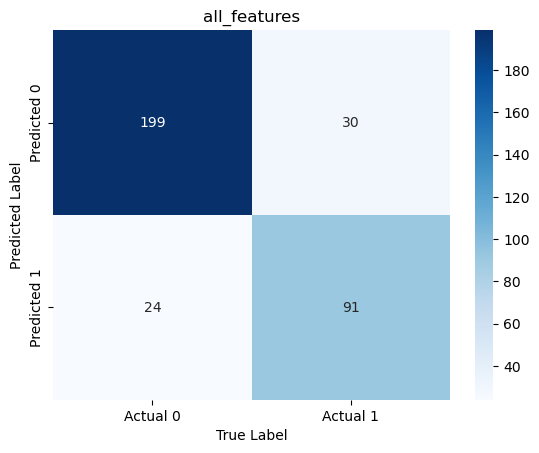

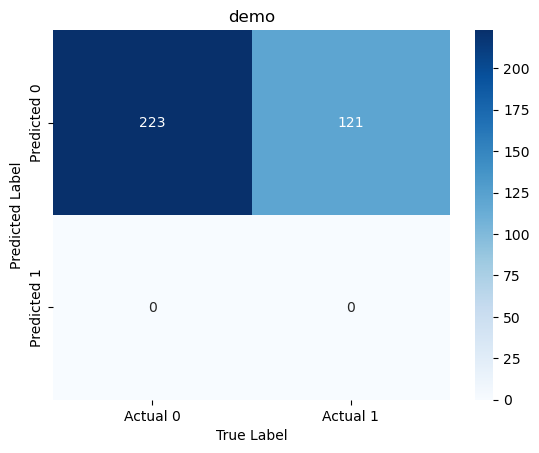

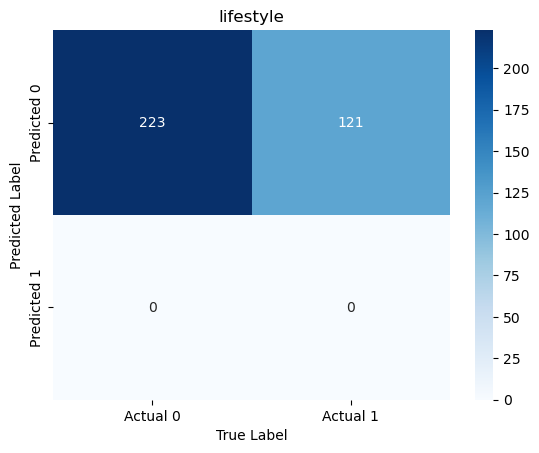

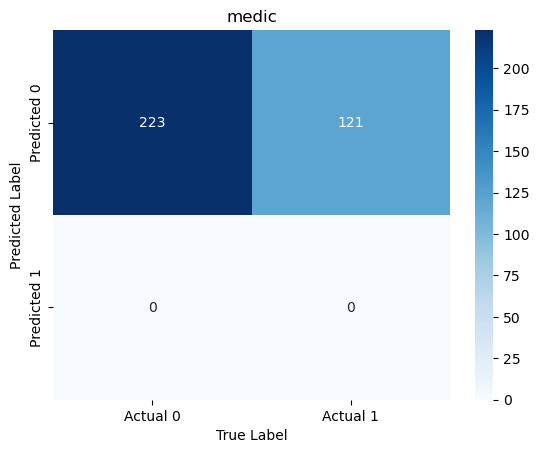

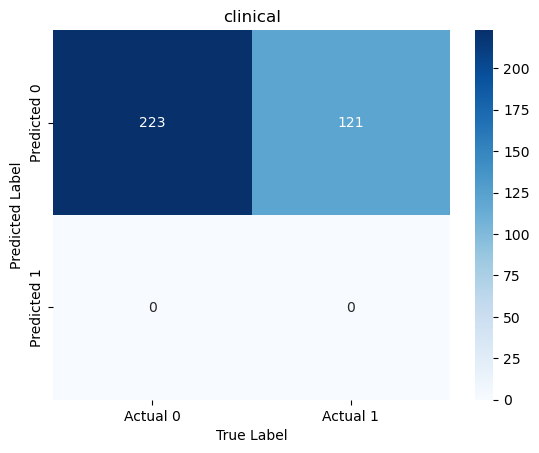

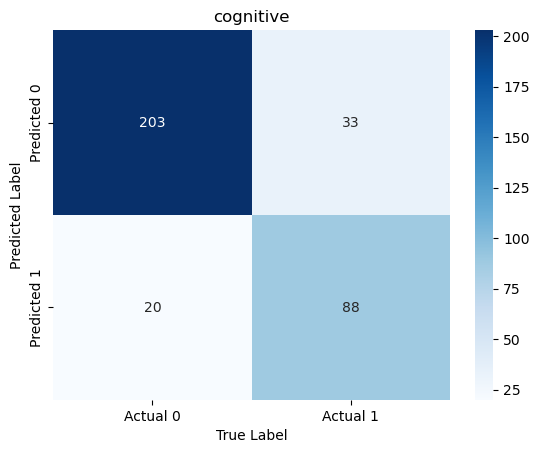

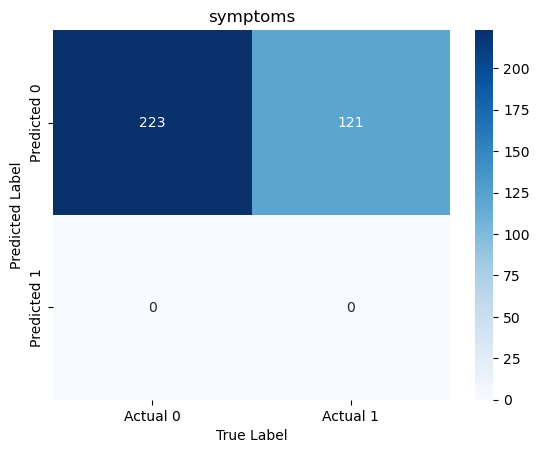

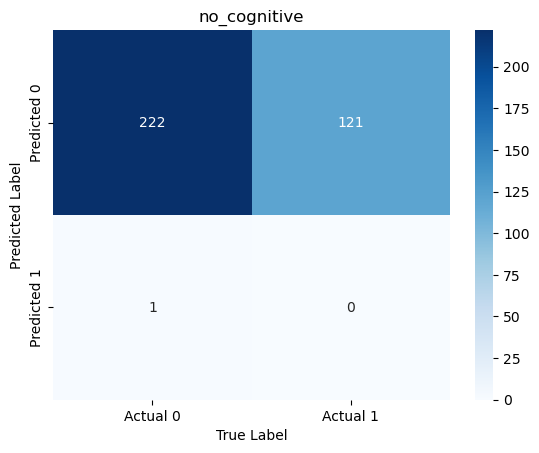

In [43]:
for key,item in lda_conf_matrix.items():
    sns.heatmap(item, annot=True, fmt="d", cmap="Blues", yticklabels=["Predicted 0", "Predicted 1"], xticklabels=["Actual 0", "Actual 1"])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.title(key)
    plt.show()

## **Quadratic Discriminant Analysis (QDA)**

In [45]:
qda_pipe = Pipeline([('scale', StandardScaler()), 
                     ('qda', QuadraticDiscriminantAnalysis())
                    ])

qda_accu_score = {}
qda_conf_matrix = {}

for key in subcategory_dict:
    item = subcategory_dict[key]
    qda_pipe.fit(df_train[item[:-1]], df_train.Diagnosis)
    pred = qda_pipe.predict(df_test[item[:-1]])

    qda_accu_score[key] = [accuracy_score(pred, df_test.Diagnosis),
                           precision_score(pred, df_test.Diagnosis, zero_division=1),
                           recall_score(pred, df_test.Diagnosis),
                           f1_score(pred, df_test.Diagnosis),
                           mean_squared_error(pred, df_test.Diagnosis)]
    qda_conf_matrix[key] = confusion_matrix(pred, df_test.Diagnosis)

qda_accu_score_df = pd.DataFrame(qda_accu_score, index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'MSE'])
qda_accu_score_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy Score,0.805233,0.648256,0.636628,0.636628,0.651163,0.848837,0.648256,0.587209
Precision Score,0.702479,0.000000,0.008264,0.049587,0.049587,0.785124,0.000000,0.239669
Recall Score,0.732759,0.000000,0.166667,0.375000,0.545455,0.785124,0.000000,0.367089
F1 Score,0.717300,0.000000,0.015748,0.087591,0.090909,0.785124,0.000000,0.290000
MSE,0.194767,0.351744,0.363372,0.363372,0.348837,0.151163,0.351744,0.412791


Since GaussianNB, LDA and QDA assume normally distributed features, I assumed it would perform worse. But it did surprisngly perform decently.

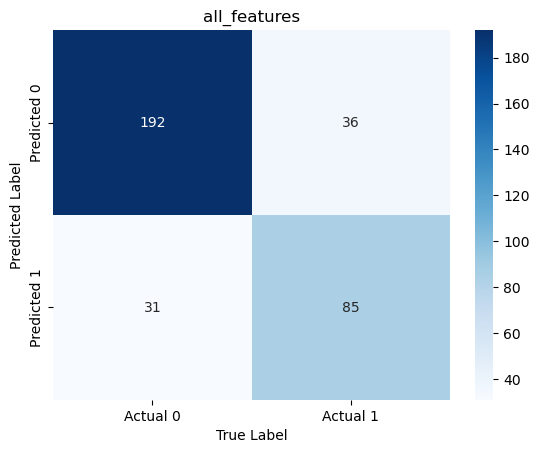

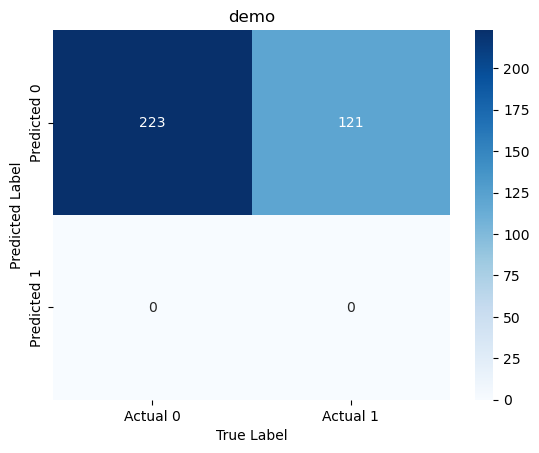

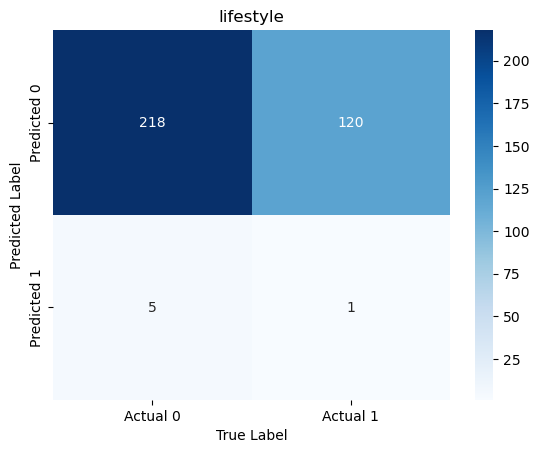

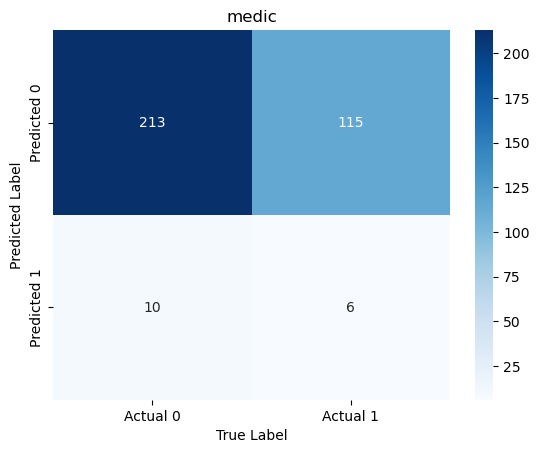

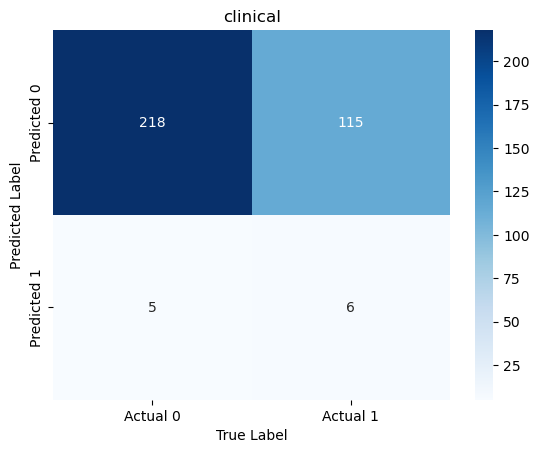

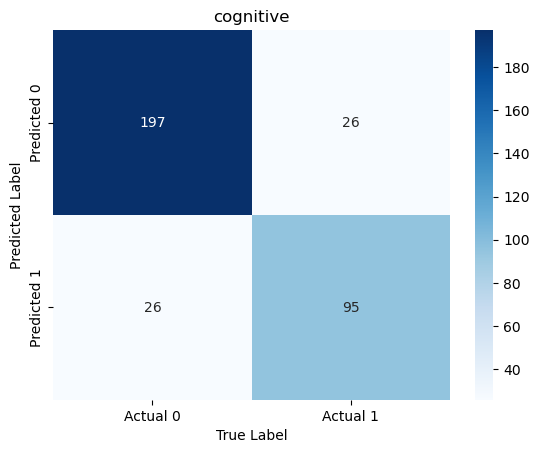

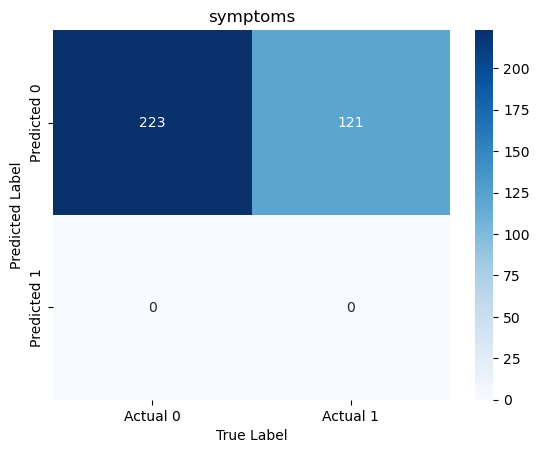

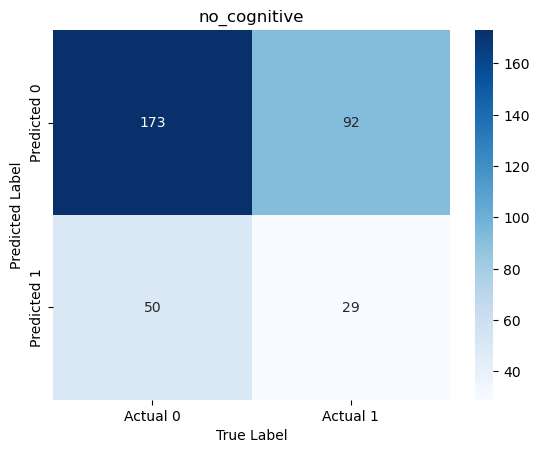

In [47]:
for key,item in qda_conf_matrix.items():
    sns.heatmap(item, annot=True, fmt="d", cmap="Blues", yticklabels=["Predicted 0", "Predicted 1"], xticklabels=["Actual 0", "Actual 1"])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.title(key)
    plt.show()